# CrossEntropyLoss with Softmax as input

#### Original tutorial: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

## Summary

- This tutorial is to show the issue of having 2 softmax layers in classification problems with only 1 line change.
- Having softmax as input of the cross entropy loss makes the loss harder to decrease, thus making the training much slower.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms


## Datasets

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")


Files already downloaded and verified
Files already downloaded and verified


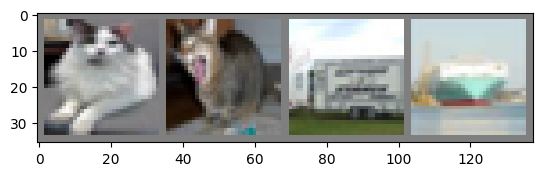

cat   cat   truck ship 


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(" ".join(f"{classes[labels[j]]:5s}" for j in range(batch_size)))


## Model

#### The only change we have is in the block below.

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.softmax(x, dim=-1)  # This line is the only change we made to show the issue
        return x


net = Net()


## Loss & Optimizer

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)


cuda:0


In [7]:
net.to(device)


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [8]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}")
            running_loss = 0.0

print("Finished Training")


[1,  2000] loss: 2.302
[1,  4000] loss: 2.302
[1,  6000] loss: 2.301
[1,  8000] loss: 2.294
[1, 10000] loss: 2.259
[1, 12000] loss: 2.233
[2,  2000] loss: 2.203
[2,  4000] loss: 2.179
[2,  6000] loss: 2.159
[2,  8000] loss: 2.133
[2, 10000] loss: 2.113
[2, 12000] loss: 2.099
Finished Training


#### We can see that the loss barely decreases compared to the original tutorial!

In [9]:
PATH = "./cifar_net_additional_softmax.pth"
torch.save(net.state_dict(), PATH)


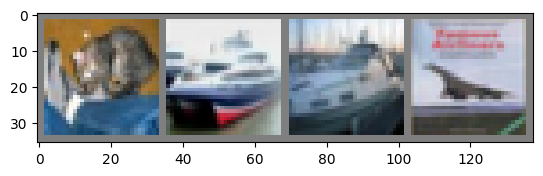

GroundTruth:  cat   ship  ship  plane


In [10]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print("GroundTruth: ", " ".join(f"{classes[labels[j]]:5s}" for j in range(4)))


## Testing

#### Of course the results are not good at all!

In [11]:
_, predicted = torch.max(outputs, 1)

print("Predicted: ", " ".join(f"{classes[predicted[j]]:5s}" for j in range(4)))


Predicted:  horse dog   plane horse


## Evaluation

#### Original tutorial has 54% of accuracy

In [12]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the 10000 test images: {100 * correct // total} %")


Accuracy of the network on the 10000 test images: 34 %


#### Original tutorial reports accuracy between 35% and 70%

In [13]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f"Accuracy for class: {classname:5s} is {accuracy:.1f} %")


Accuracy for class: plane is 39.4 %
Accuracy for class: car   is 20.7 %
Accuracy for class: bird  is 15.9 %
Accuracy for class: cat   is 10.8 %
Accuracy for class: deer  is 22.3 %
Accuracy for class: dog   is 27.2 %
Accuracy for class: frog  is 44.2 %
Accuracy for class: horse is 54.4 %
Accuracy for class: ship  is 46.2 %
Accuracy for class: truck is 68.1 %


## Wrap Up

- In PyTorch, CrossEntropy can be seen as Softmax + Negative Log Likelihood, i.e., Softmax operation is present when using torch.nn.CrossEntropyLoss().

- The reason why having an additional Softmax layer degrades the performance is that Softmax is a normalizer (probability distribution).
  - A distribution of (2, 3, 5) will be normalized to (0.04, 0.11, 0.84) after the exponential operation in Softmax.
  - The gradients received by the logits are also shrinked, as if the learning rate is reduced.
  - The nodes in the layer never receives correct gradients, thus the results are incorrect.

- Therefore, the inputs of the `nn.CrossEntropyLoss()` should be logits, not the probabilities.
  - Either, pass the logits directly: `loss = torch.nn.CrossEntropyLoss()(logits, targets)`;
  - Or, calculate the softmax: `log_probs = torch.nn.functional.log_softmax(logits)`, then use negative log likelihodd: `loss = torch.nn.functional.nll_loss(log_probs, targets)`.
  - Note that PyTorch `nll_loss` does not have `log` operation although the name `nll` implies negative log likelihood. Therefore there is only 1 log function in the second approach above.